# Salary Predictions Based on Job Descriptions

### DEFINING THE PROBLEM

Write the problem in your own words here

### Importing required libraries

In [1]:
#author info 
__author__ = "Harini S"
__email__ = "harini.narayanan18@gmail.com"

In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import sklearn as sk
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
from tqdm import tqdm

%matplotlib inline

### Reading the data

In [3]:
#loading training features data into a Pandas dataframe
train_features_data = pd.read_csv('D:/SalaryPredictions/data/train_features.csv')
train_features_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
#loading training target data into a pandas dataframe
train_salaries_data = pd.read_csv('D:/SalaryPredictions/data/train_salaries.csv')
train_salaries_data.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [89]:
#loading the test data into a pandas dataframe
test_features_data = pd.read_csv('D:/SalaryPredictions/data/test_features.csv')
test_features_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### EXPLORING THE DATA

#### 1) Shape of the data

In [6]:
shape_data = [train_features_data.shape, train_salaries_data.shape, test_features_data.shape]
shape_df = pd.DataFrame(data = shape_data, index = ['train features shape', 'train salaries shape', 'test features shape'],columns = ['Rows', 'Columns'])
shape_df

,Rows,Columns
train features shape,1000000,8
train salaries shape,1000000,2
test features shape,1000000,8


#### 2) Checking for null values

In [7]:
train_features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [8]:
train_salaries_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [9]:
test_features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


#### Our data has no missing values. 

#### 3) Let's check for duplicates.

In [10]:
#checking for duplicates (all columns match) in training data
duplicate = train_features_data[train_features_data.duplicated()] 
duplicate

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


In [11]:
#checking for duplicates (all columns match) in test data
test_duplicate = test_features_data[test_features_data.duplicated()] 
test_duplicate

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


##### Looks like we have no duplicates.

In [72]:
del duplicate
del test_duplicate


#### 4) Next, checking categorical columns for invalid inputs by taking value_counts

In [12]:
train_features_data['jobType'].value_counts()

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64

In [13]:
train_features_data['degree'].value_counts()

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [14]:
train_features_data['major'].value_counts()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

In [15]:
train_features_data['industry'].value_counts()

WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64

#### Our data has no invalid / single unique data point.

#### 5) Let's check if the numerical data make sense. i.e we don't want negative salaries, years of experience, miles from Metropolis.

In [16]:
train_features_data.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [17]:
train_salaries_data.describe()

,salary
count,1000000.000000
mean,116.061818
std,38.717936
min,0.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


##### We see that there are salaries which have zero as their value. We will remove these rows after merging the two training datasets.

In [18]:
# Exploring upper and lower quartiles of the target variable

dataset = train_salaries_data.salary.describe()
#print(dataset)
IQR = dataset['75%']-dataset['25%']
upper_limit = dataset['75%'] + (1.5*IQR)
lower_limit = dataset['25%'] - (1.5*IQR)
print("The upper outlier limit is:", upper_limit)
print("The lower outlier limit is:", lower_limit)

The upper outlier limit is: 220.5
The lower outlier limit is: 8.5


### Merging the training features data with its corresponding targets

In [19]:
#Checking number of unique values in each column
train_features_data.nunique()

jobId                  1000000
companyId                   63
jobType                      8
degree                       5
major                        9
industry                     7
yearsExperience             25
milesFromMetropolis        100
dtype: int64

In [20]:
train_salaries_data.nunique()

jobId     1000000
salary        280
dtype: int64

##### We can see that Job ID seems to be unique and therefore we shall use it to merge the two dataframes.

#### Merging both train_features dataframe and train_salaries dataframe based on jobId column

In [21]:
training_data = pd.merge(train_features_data, train_salaries_data, on='jobId')
training_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [22]:
training_data.shape

(1000000, 9)

#### Deleting individual dataframes to free up memory

In [23]:
del train_features_data
del train_salaries_data

In [24]:
#Checking the data types of all columns
training_data.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [25]:
#Let's change our Target column value to type 'float' since we want it to be a continuous variable

training_data['salary'] = training_data['salary'].astype(float)

In [26]:
training_data.dtypes

jobId                   object
companyId               object
jobType                 object
degree                  object
major                   object
industry                object
yearsExperience          int64
milesFromMetropolis      int64
salary                 float64
dtype: object

In [27]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 76.3+ MB


#### Exploring outliers on LHS and RHS

First let's look at the outliers on the lower end of the salary and then at the outliers on the higher end of the salary column. Outliers that don't make sense will be removed from the dataset.

In [28]:
training_data[training_data['salary'] <= lower_limit]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0.0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0.0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0.0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0.0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0.0


##### Dropping the rows where salary is 0 and resetting the index.

In [29]:
training_data = training_data[training_data['salary'] > lower_limit]
training_data

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130.0
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101.0
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137.0
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142.0
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163.0
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113.0
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178.0
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73.0
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31.0
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104.0


In [30]:
training_data.shape

(999995, 9)

In [31]:
training_data.reset_index(drop=True,inplace=True)
training_data

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130.0
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101.0
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137.0
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142.0
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163.0
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113.0
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178.0
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73.0
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31.0
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104.0


In [32]:
# Exploring the outliers at the upper end of the salary distribution
training_data.loc[training_data.salary > upper_limit, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

##### JUNIOR positions having such high salaries seem like an anomaly. Therefore, we'll look into those alone.

In [33]:
# Explore the outliers at the upper end of the salary distribution where job level 'Junior'
training_data[(training_data.salary > upper_limit) & (training_data.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225.0
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246.0
31354,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225.0
100041,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248.0
160332,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223.0
189581,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221.0
214605,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222.0
303777,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226.0
348353,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226.0
427592,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221.0


##### The majority of people with high pay in Junior positions seem to have advanced degrees like MBA or PhD and / or wokring in the Oil / Finance industry. These industries are generally highly paid, and thus we retain these outliers.

#### Exploring the target variable : Salary

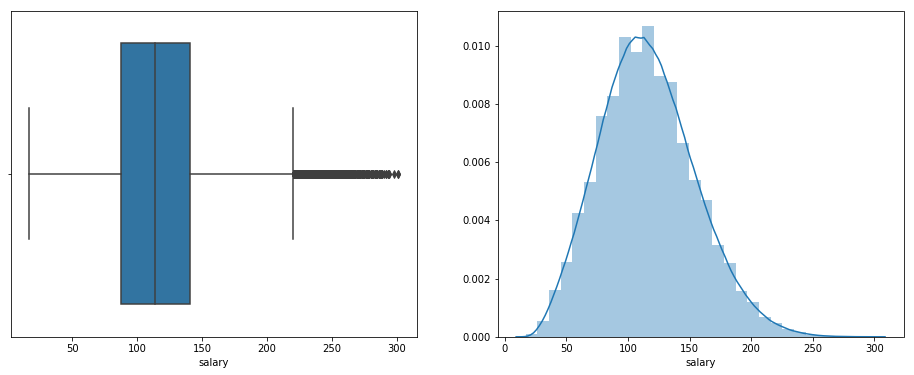

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.boxplot(training_data.salary)
plt.subplot(1, 2, 2)
sns.distplot(training_data.salary, bins=30)
plt.show()

#### The distribution seems Gaussian with a slight positive skew, which makes sense from our box plot.

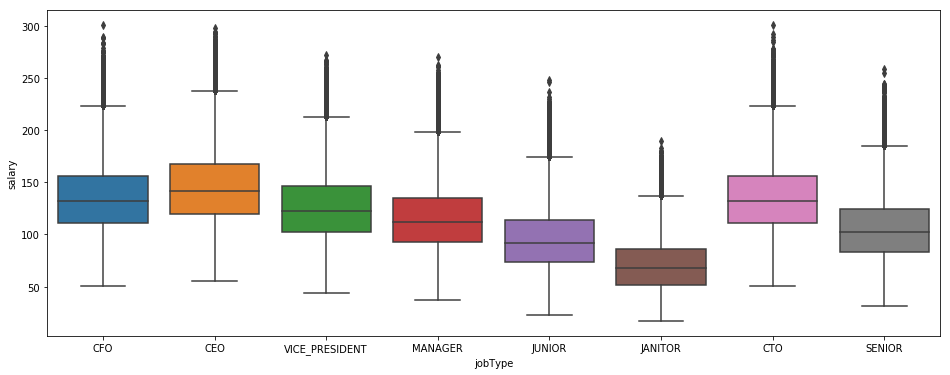

In [35]:
#Making a boxplot of various job types with salaries.
plt.figure(figsize=(16, 6))
sns.boxplot(x = training_data.jobType, y = training_data.salary)

##### Janitors get paid the lowest and people who are CEOs get paid the highest.

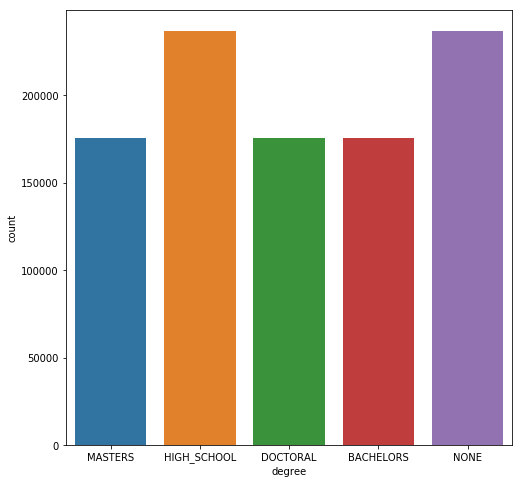

In [36]:
plt.figure(figsize=(8,8))
sns.countplot(x=training_data.degree)


##### In our data, more people either have a high school degree or no degrees. The number of people who seem to have a bachelors or a masters or a doctoral degree seems to be almost equal in the dataset

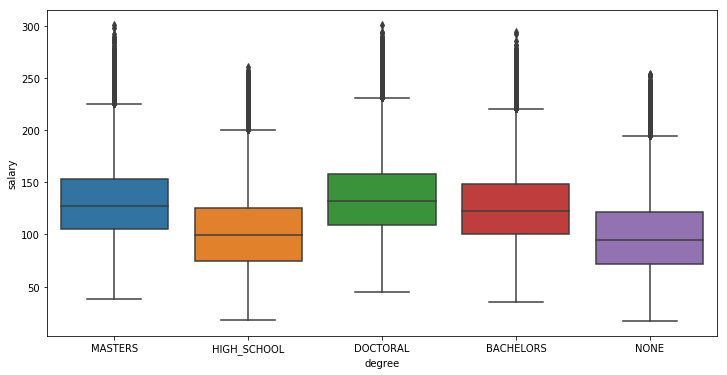

In [37]:
#Making a boxplot of various degrees with salaries.
plt.figure(figsize=(12, 6))
sns.boxplot(x = training_data.degree, y = training_data.salary)

##### People with no degrees or just a high school degree, on an average, tend to be on the lower end of the income whereas people with a masters or a doctoral degree seem to be on the higher end.

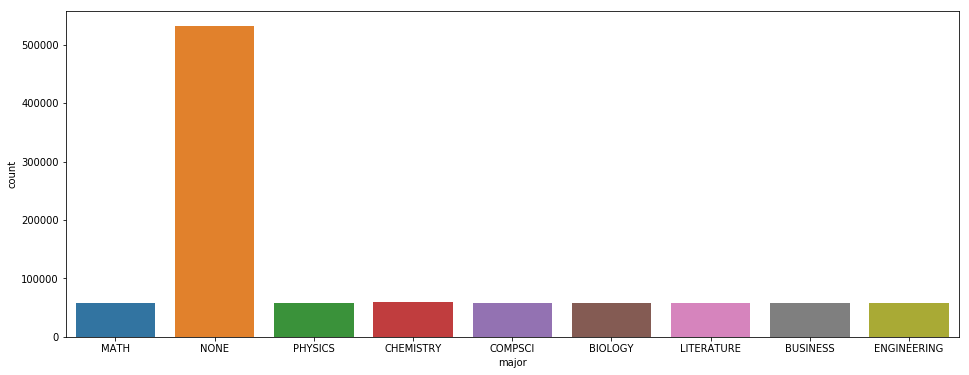

In [38]:
plt.figure(figsize=(16,6))
sns.countplot(x=training_data.major)

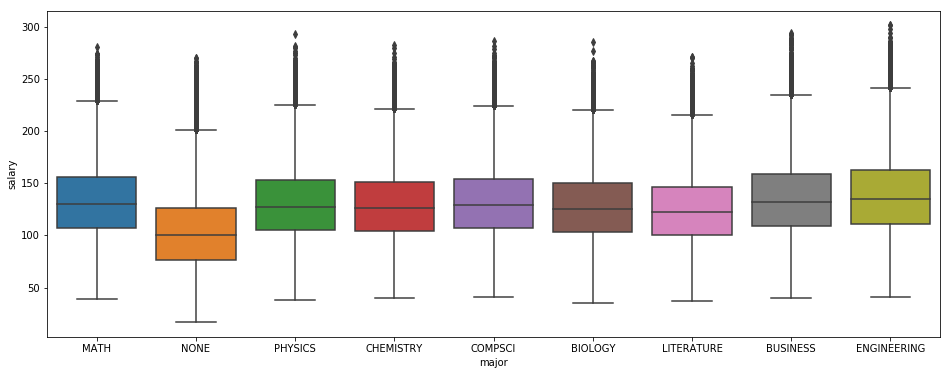

In [39]:
#Making a boxplot of various majors with salaries.
plt.figure(figsize=(16, 6))
sns.boxplot(x = training_data.major, y = training_data.salary)

##### There seems to be only marginal differences in salary earned based on people's major. People with no major are probably ones who didn't go to college and hence are on the lower income end.

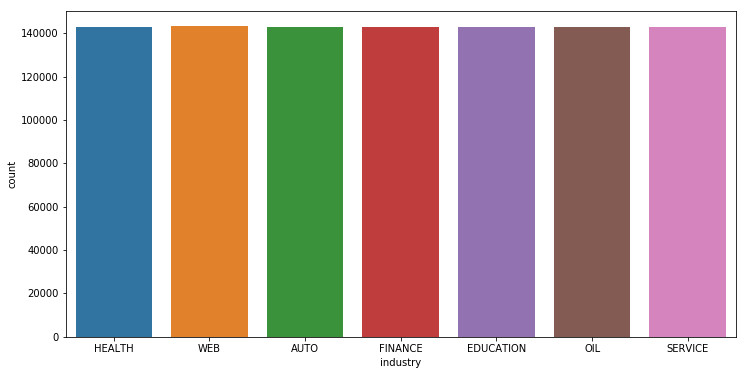

In [40]:
plt.figure(figsize=(12,6))
sns.countplot(x=training_data.industry)

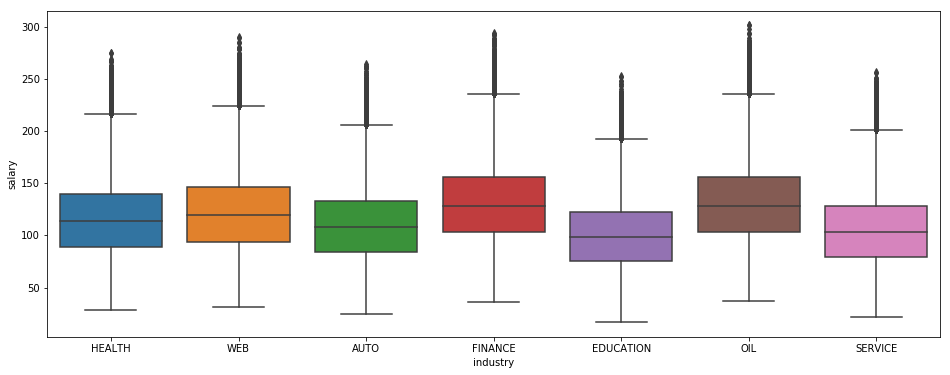

In [41]:
#Making a boxplot of various majors with salaries.
plt.figure(figsize=(16, 6))
sns.boxplot(x = training_data.industry, y = training_data.salary)

##### The data contains almost equal number of people working in all the different industries. People working in Oil and Finance industries seem to be earning higher than other industries

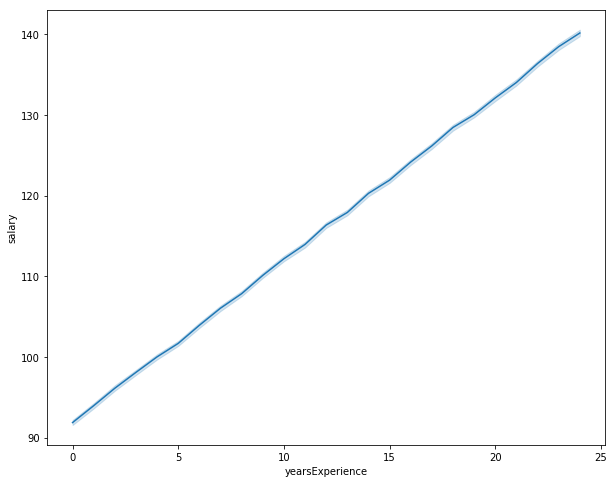

In [42]:
plt.figure(figsize=(10,8))
sns.lineplot(x=training_data.yearsExperience, y=training_data.salary)

##### There seems to be a positive correlation between the years of experience a person has and the salary they earn

##### Next, we'll use label encoding to convert categorical variables to numerical ones before finding correlated variables.

Here I'm using label encoding instead of one-hot encoding for two reasons:

1) There is a clear order present in some of the categorical variables (i.e they are ordinal). For instance, degree has high school < bachelors < masters < doctoral. Same with Job Type variable which has a hierarchy.


2) There are too many categories in each categorical variable. So if we do one-hot encoding, we'll end up with a ton of data! Which won't be easy to work with especially since we do have nearly a million rows. So I am trying to keep the number of columns to a minimum.

In [43]:
#Function for encoding categorical data
def Encode_Data(df):    
    for col in df.columns:
        if df[col].dtype.name == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
    return df

In [44]:
# Creating a copy of the dataset and encode the categorical data
train_df = training_data.copy()

In [45]:
train_df = Encode_Data(train_df)

In [46]:
train_df

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,0,31,1,3,6,3,10,83,130.0
1,1,11,0,2,7,6,3,73,101.0
2,2,48,7,1,8,3,10,38,137.0
3,3,32,5,1,2,0,8,17,142.0
4,4,60,7,0,8,2,8,16,163.0
5,5,7,5,1,3,2,2,31,113.0
6,6,7,1,4,7,3,23,24,178.0
7,7,17,4,0,2,1,9,70,73.0
8,8,13,3,2,7,1,1,54,31.0
9,9,36,7,0,2,0,17,68,104.0


In [47]:
#dropping job ID since it's all unique values and we dont need it for analysis
train_df.drop('jobId',axis=1,inplace= True)
train_df

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,31,1,3,6,3,10,83,130.0
1,11,0,2,7,6,3,73,101.0
2,48,7,1,8,3,10,38,137.0
3,32,5,1,2,0,8,17,142.0
4,60,7,0,8,2,8,16,163.0
5,7,5,1,3,2,2,31,113.0
6,7,1,4,7,3,23,24,178.0
7,17,4,0,2,1,9,70,73.0
8,13,3,2,7,1,1,54,31.0
9,36,7,0,2,0,17,68,104.0


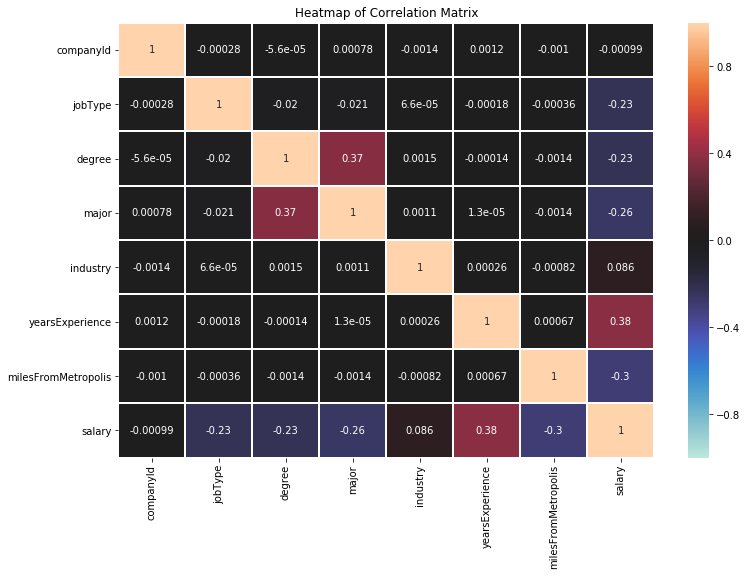

In [48]:
# Plot seaborn heatmap to visualize correlation between variables
plt.figure(figsize = (12, 8))
corr = train_df.corr()
sns.heatmap(corr,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,cmap = "icefire", vmin=-1, vmax=1, annot=True, linewidths=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

##### From the heat map and the previous plots, we see that years of experience is the most positively correlated variable with salary (i,e both increase together) and miles from metropolis is the most negatively correlated with salary (ie the higher the miles, the lower the salary and vice versa).

The correlation numbers for other features are not very significant / are negligible.


### ESTABLISHING A BASELINE MODEL

Fitting a basic linear regression model. After finding out the MSE from that, we'll fine tune the model or fit better ones.

#### Linear Regression

In [49]:
train_df_features = train_df[['companyId','jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']]
train_df_target = train_df[['salary']]

In [50]:
lin_reg = LinearRegression()

In [51]:
lin_reg.fit(X = train_df_features, y = train_df_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
baseline_mse = cross_val_score(lin_reg, train_df_features, train_df_target, scoring = 'neg_mean_squared_error')
baseline_mse

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([-926.88524956, -926.21514714, -922.23461129])

In [53]:
baseline_mse = -1*baseline_mse.mean()
print("Baseline MSE Score: ",baseline_mse)

Baseline MSE Score:  925.1116693327762


##### Our job is to try and reduce the MSE as much as possible. 

### HYPOTHESIZING SOLUTIONS

#### KNN Regression

1) Split the data into training and testing sets

2) Scale the data

3) Try various values of 'k' neighbours for the data to find the lowest MSE

In [54]:
train, test = train_test_split(train_df, test_size = 0.3)

x_train = train.drop('salary', axis=1)
y_train = train['salary']

x_test = test.drop('salary', axis = 1)
y_test = test['salary']

In [55]:
#Scaling the values is an important step while using KNN 
#since feature similarities are calculated based on the distance

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [56]:
#Trying various number of neighbours and calculating MSE for each fit
mse_val = [] #to store mse values for different k
for K in tqdm(range(25)):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate mse
    mse_val.append(error) #store mse values
    print('MSE value for k= ' , K , 'is:', error)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

MSE value for k=  1 is: 718.7564225214084


  4%|███▎                                                                               | 1/25 [00:57<22:51, 57.16s/it]

MSE value for k=  2 is: 540.1226120753736


  8%|██████▋                                                                            | 2/25 [01:58<22:22, 58.36s/it]

MSE value for k=  3 is: 482.59879977377716


 12%|█████████▉                                                                         | 3/25 [03:04<22:14, 60.67s/it]

MSE value for k=  4 is: 454.6719422398075


 16%|█████████████▎                                                                     | 4/25 [04:14<22:12, 63.44s/it]

MSE value for k=  5 is: 437.7343276477589


 20%|████████████████▌                                                                  | 5/25 [05:36<22:58, 68.94s/it]

MSE value for k=  6 is: 427.01402615786486


 24%|███████████████████▉                                                               | 6/25 [06:51<22:29, 71.00s/it]

MSE value for k=  7 is: 419.15708521749497


 28%|███████████████████████▏                                                           | 7/25 [08:11<22:02, 73.48s/it]

MSE value for k=  8 is: 414.1369610815369


 32%|██████████████████████████▌                                                        | 8/25 [09:32<21:27, 75.71s/it]

MSE value for k=  9 is: 410.20681760297236


 36%|█████████████████████████████▉                                                     | 9/25 [10:55<20:49, 78.08s/it]

MSE value for k=  10 is: 406.92785165950556


 40%|████████████████████████████████▊                                                 | 10/25 [12:21<20:06, 80.43s/it]

MSE value for k=  11 is: 404.86130226494686


 44%|████████████████████████████████████                                              | 11/25 [13:49<19:15, 82.55s/it]

MSE value for k=  12 is: 403.055818611988


 48%|███████████████████████████████████████▎                                          | 12/25 [15:18<18:20, 84.67s/it]

MSE value for k=  13 is: 401.3815561436486


 52%|██████████████████████████████████████████▋                                       | 13/25 [16:50<17:22, 86.84s/it]

MSE value for k=  14 is: 400.0944574237015


 56%|█████████████████████████████████████████████▉                                    | 14/25 [18:24<16:18, 88.93s/it]

MSE value for k=  15 is: 399.1939254167884


 60%|█████████████████████████████████████████████████▏                                | 15/25 [19:59<15:08, 90.87s/it]

MSE value for k=  16 is: 398.596459943929


 64%|████████████████████████████████████████████████████▍                             | 16/25 [21:37<13:57, 93.01s/it]

MSE value for k=  17 is: 398.1788202615807


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [23:20<12:46, 95.81s/it]

MSE value for k=  18 is: 398.0061838992138


 72%|███████████████████████████████████████████████████████████                       | 18/25 [25:01<11:21, 97.35s/it]

MSE value for k=  19 is: 397.9125480741445


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [26:43<09:53, 98.89s/it]

MSE value for k=  20 is: 397.9114968216561


 80%|████████████████████████████████████████████████████████████████▊                | 20/25 [28:49<08:54, 106.87s/it]

MSE value for k=  21 is: 397.9412963198162


 84%|████████████████████████████████████████████████████████████████████             | 21/25 [30:34<07:06, 106.57s/it]

MSE value for k=  22 is: 398.0877423241548


 88%|███████████████████████████████████████████████████████████████████████▎         | 22/25 [32:30<05:27, 109.21s/it]

MSE value for k=  23 is: 398.3264204138399


 92%|██████████████████████████████████████████████████████████████████████████▌      | 23/25 [34:31<03:45, 112.83s/it]

MSE value for k=  24 is: 398.62027459073016


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 24/25 [37:49<02:18, 138.32s/it]

MSE value for k=  25 is: 398.8222166500557


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [41:44<00:00, 167.33s/it]


In [57]:
knn_mse = min(mse_val)
print('The minimum MSE achieved through KNN regression is ', knn_mse, "at k = ", mse_val.index(min(mse_val))+1 )

The minimum MSE achieved through KNN regression is  397.9114968216561 at k =  20


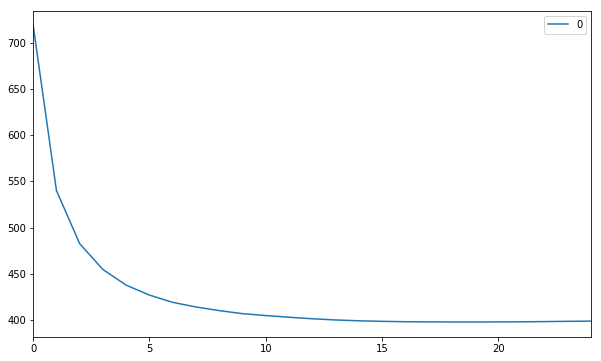

In [58]:
#plotting the mse values against k values
curve = pd.DataFrame(mse_val) #elbow curve 
curve.plot(figsize=(10,6))

#### Result of KNN

We can see that the lowest MSE we get from KNN is 399 which corresponds to selecting 20 nearest neighbours. 
399 is a great MSE compared to the MSE we got from Linear regression but we'll still try to reduce the MSE by using other methods.

### Random Forest Regressor

1) Fit the random forest regressor model to training data

2) Predict values for x_test and find the MSE by comparing with actual y_test values

In [59]:
rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, max_depth=30, min_samples_split=60, max_features='sqrt')
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=60,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
rf_pred = rf.predict(x_test)

In [61]:
rf_mse = mean_squared_error(y_test, rf_pred)
print("The MSE as calculated by using Random forest regression is: ", rf_mse)

The MSE as calculated by using Random forest regression is:  381.57385172914866


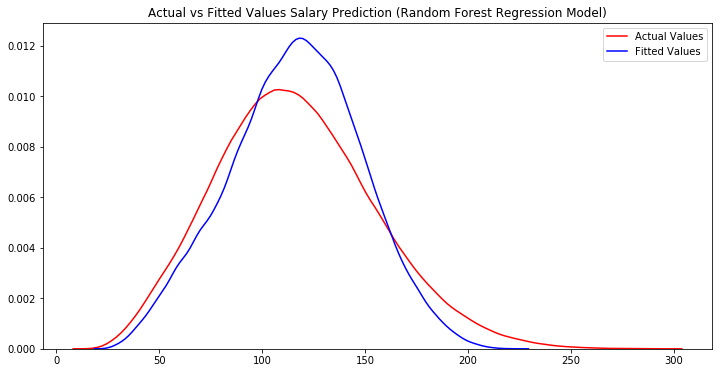

In [62]:
# Random Forest Regression Model evaluation using visualisation
plt.figure(figsize=(12,6))
ax1=sns.kdeplot(y_test,color='r',label="Actual Values")
ax1=sns.kdeplot(rf_pred,color='b',label="Fitted Values")
plt.legend()
plt.title("Actual vs Fitted Values Salary Prediction (Random Forest Regression Model)")
plt.show()

### XGBOOST REGRESSION

1) Fit the XGBoost regressor model to training data

2) Predict values for x_test and find the MSE by comparing with actual y_test values

In [63]:
xgb = xgboost.XGBRegressor(max_depth=5, n_estimators=500, learning_rate=0.1, n_jobs=-1)

In [64]:
xgb.fit(x_train, y_train)

C:\Users\Admin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Admin\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:58:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [65]:
xgb_pred = xgb.predict(x_test)

In [66]:
xgb_mse = mean_squared_error(y_test, xgb_pred)
print("The MSE as calculated by using XG boost regression is: ", xgb_mse)

The MSE as calculated by using XG boost regression is:  356.2493589206488


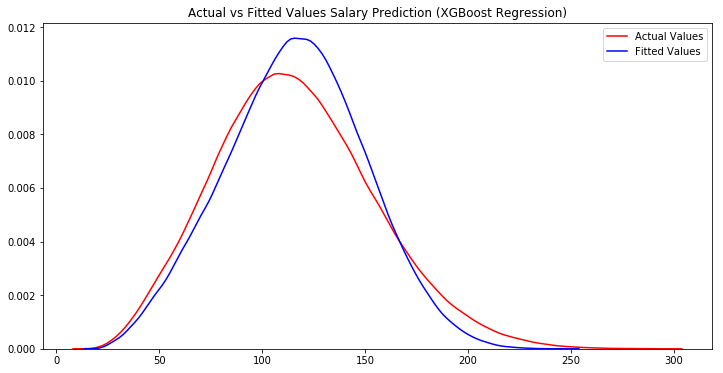

In [67]:
# Random Forest Regression Model evaluation using visualisation
plt.figure(figsize=(12,6))
ax1=sns.kdeplot(y_test,color='r',label="Actual Values")
ax1=sns.kdeplot(xgb_pred,color='b',label="Fitted Values")
plt.legend()
plt.title("Actual vs Fitted Values Salary Prediction (XGBoost Regression)")
plt.show()

### Summarizing the models

In [68]:
analysis = [["Linear Regression", baseline_mse],["KNN Regression", knn_mse],["Random Forest Regression", rf_mse],["XGBoost Regression", xgb_mse]]

In [69]:
summary = pd.DataFrame(analysis)
summary.columns = ['Model','MSE']
summary

,Model,MSE
0,Linear Regression,925.111669
1,KNN Regression,397.911497
2,Random Forest Regression,381.573852
3,XGBoost Regression,356.249359


#### eXtreme Gradient Boosting regression seems to be doing the best job for our dataset in minimising the Mean Squared Error.

We will use the same model for our test data and further deployment.

### TEST DATA

In [90]:
#Looking at test data
test_features_data

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


In [91]:
#Dropping JOB ID column
test_features_data.drop('jobId',axis=1,inplace=True)
test_features_data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [92]:
#Label encoding categorical features in test data
test_df = test_features_data.copy()
test_df = Encode_Data(test_df)
test_df.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,27,5,2,7,3,22,73
1,5,4,4,7,0,20,47
2,2,2,3,0,3,17,9
3,14,5,2,7,4,14,96
4,30,4,1,0,4,10,44


In [93]:
test_features_data

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


In [94]:
test_df = scaler.fit_transform(test_df)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [95]:
test_df = pd.DataFrame(test_df)

In [96]:
#Obtain predictions
xgb_test_predictions = xgb.predict(test_df)
xgb_test_predictions

array([111.65739 ,  91.513115, 183.39357 , ...,  54.621746, 162.20744 ,
       111.71849 ], dtype=float32)

In [97]:
predicted_test_data = pd.DataFrame(xgb_test_predictions)
predicted_test_data.head()

,0
0,111.657387
1,91.513115
2,183.393570
3,104.905937
4,115.262978


In [98]:
final_predictions = pd.concat([test_features_data,predicted_test_data],axis=1)
final_predictions.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,0
0,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,111.657387
1,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,91.513115
2,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,183.393570
3,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,104.905937
4,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,115.262978
5,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23,154.195465
6,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32,98.046204
7,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73,121.696274
8,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78,107.388107
9,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97,97.065826


In [99]:
final_predictions = final_predictions.rename(columns={0: "Salary"})
final_predictions.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,Salary
0,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,111.657387
1,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,91.513115
2,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,183.393570
3,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,104.905937
4,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,115.262978


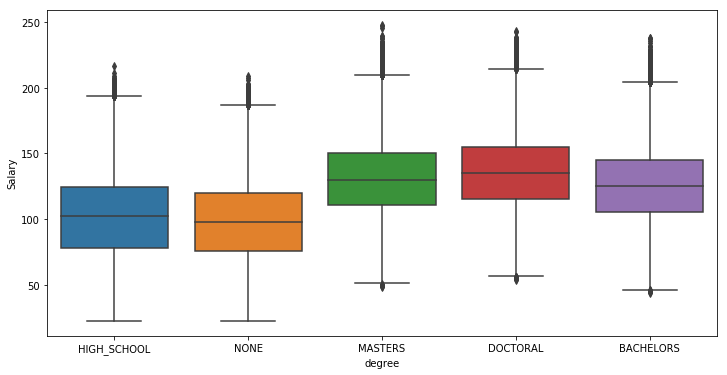

In [102]:
#Making a boxplot of various degrees with predicted salaries to see 
#if it looks more or less similar to the boxplot we made from training data
plt.figure(figsize=(12, 6))
sns.boxplot(x = final_predictions.degree, y = final_predictions.Salary)

### SAVE PREDICTIONS 

In [103]:
final_predictions.to_csv("SalaryPredictions/data/predicted_salaries.csv", index=False)